# Liquid surface

Detailed here is the reduction of reflectometry from a liquid surface, such that the sample surface is horizontally oriented and the I07 double crystal deflector system is used to position the X-ray beam.
Here, we show the reduction of reflectometry collected from a water-surface in air (note that the water was slightly "dirty" so the curve does not perfectly match pure water). 

The first task is to enure that the necessary modules and packages have been imported.

In [1]:
# Import plotting and numpy libraries
import matplotlib.pyplot as plt
import numpy as np

# islatu uses the uncertainties library for 
# uncertainty propagation
from uncertainties import ufloat
from uncertainties import unumpy as unp

# islatu is the data reduction pacakge
from islatu.refl_data import Profile
from islatu.io import i07_dat_parser
from islatu.cropping import crop_around_peak_2d
from islatu.background import fit_gaussian_2d
from islatu.corrections import get_interpolator
from islatu.image import Image

## Parsing data

Once everything has been imported, we must define the files, in this case they are I07 `.dat` files, that will be reduced. 
Remember that due to the changes in attenutation a full reflectometry curve typically contains 3-5 scans. 
In this example, five scans where performed and the files are called `refl_1.dat` to `refl_5.dat`. 

In [2]:
files = ['refl_{}.dat'.format(i) for i in range(1, 6)]

In [3]:
print(files)

['refl_1.dat', 'refl_2.dat', 'refl_3.dat', 'refl_4.dat', 'refl_5.dat']


This list of files is passed to the `islatu.refl_data.Profile` object, we must also inform this function what parsing function should be used. 
In this case, as we are detailing with I07 `.dat` files, we use `islatu.io.i07_dat_parser`. 

In [4]:
refl = Profile(files, i07_dat_parser)

The `refl` object possesses a class object called `scans`, which is a list of the scan contained in the `.dat` files.

In [5]:
for i in refl.scans:
    print(i)

The file: refl_1.dat contains 61 images from q = 0.01 to q = 0.04.
The file: refl_2.dat contains 15 images from q = 0.03 to q = 0.1.
The file: refl_3.dat contains 14 images from q = 0.07 to q = 0.2.
The file: refl_4.dat contains 19 images from q = 0.16 to q = 0.34.
The file: refl_5.dat contains 16 images from q = 0.3 to q = 0.6.


In total, we have data ranging from $q=0.01$ Å<sup>-1</sup> to $q = 0.6$ Å<sup>-1</sup>. 

## Reducing images

Reflectometry data is collected at I07 as a series of detector images, like that shown below.

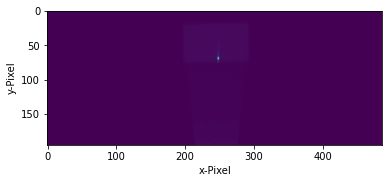

q = 0.5 Å


In [6]:
im = Image(refl.scans[-1].data['file'][10])
plt.imshow(im.n)
plt.xlabel('x-Pixel')
plt.ylabel('y-Pixel')
plt.show()
print('q = {} Å'.format(refl.scans[-1].q[10].n))

This is data from $q = 0.5$ Å<sup>-1</sup>. 
The point in the middle of this image is the reflected intensity peak that we want to obtain, therefore it is necessary to crop this image down (to get rid of the unnecessary, blank pixels).

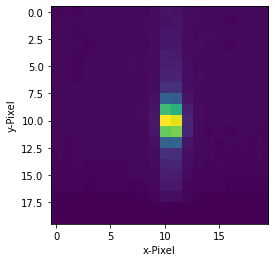

In [7]:
im.crop(crop_around_peak_2d)
plt.imshow(im.n)
plt.xlabel('x-Pixel')
plt.ylabel('y-Pixel')
plt.show()

Having reduced the size of the image and focused on the peak, we now need to perform a subtraction of the background signals. 
This signal can be seen if we reduce the dimensionality of the plot by summing along the y-axis of the image.

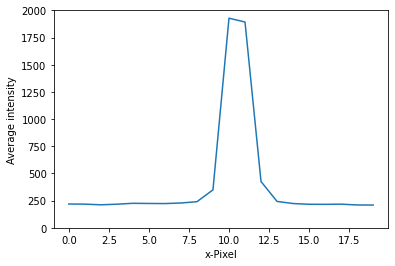

In [8]:
plt.plot(im.n.mean(axis=0))
plt.xlabel('x-Pixel')
plt.ylabel('Average intensity')
plt.ylim(0, 2000)
plt.show()

Notice that the background level is around 250 counts.
It is necessary to remove this for our data to be accurate when modelling is applied later. 

The background subtraction is performed by fitting a two-dimensional Gaussian function, with some offset from the ordinate, to the image. 
The amount by which the fit is offset from the ordinate is then subtracted from each pixel of the image.

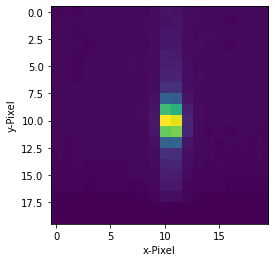

In [9]:
im.background_subtraction(fit_gaussian_2d)
plt.imshow(im.n)
plt.xlabel('x-Pixel')
plt.ylabel('y-Pixel')
plt.show()

The image above does not appear to have changed, but the background subtraction is visible when the dimensionality is reduced again. 

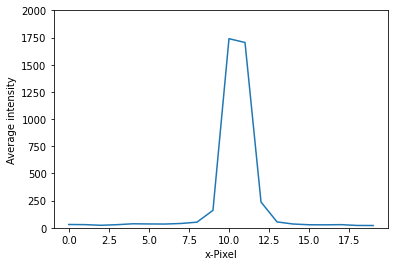

In [10]:
plt.plot(im.n.mean(axis=0))
plt.xlabel('x-Pixel')
plt.ylabel('Average intensity')
plt.ylim(0, 2000)
plt.show()

The background level is stored in the `image.Image` object. 

In [11]:
print(im.bkg)

188+/-5


Above, we have performed the cropping and background subtraction on a single image, a single $q$-vector. 
However, it is necessary to perform this operation on all of the images, this is achieved through the `crop_and_bkg_sub` class method for the `refl` object.
So to perform this process on each `.dat` file we run the following. 

In [12]:
refl.crop_and_bkg_sub(crop_around_peak_2d, fit_gaussian_2d)

100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


This is the slowest process in the data reduction. 

The $q$-uncertainty can be assigned based on the shape of the two-dimensional Gaussian function which is fitted to the image.

In [13]:
refl.q_uncertainty_from_pixel()

## Intensity reduction

The image intensity is the summed to give the *unnormalised* reflected intensity, and associated uncertainties.

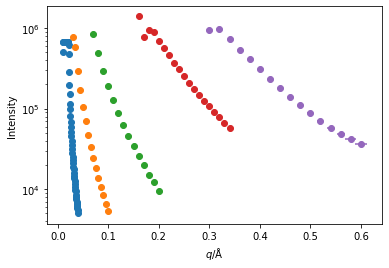

In [14]:
for s in refl.scans:
    plt.errorbar(unp.nominal_values(s.q), 
                 unp.nominal_values(s.R), 
                 yerr=unp.std_devs(s.R),
                 xerr=unp.std_devs(s.q), 
                 ls='',
                 marker='o')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'Intensity')
plt.yscale('log')
plt.show()

The first correction is due to the DCD $q$-dependence, this is due to slight deviations in the DCD crystals that lead to changes in the incident radiation intensity.
The normalisation curve should have been collected during your beamtime, the `.dat` file that contains this curve should be assigned below.

In [15]:
normalisation_file = 'qdcd_norm.dat'

This normalisation curve is interpolated, as it consists of discrete points which may not match perfectly to the measured $q$, again the `i07_dat_parser` is used as this `.dat` file is from I07.
Once interpolated, we can perform the DCD-normalisation

In [16]:
itp = get_interpolator(normalisation_file, i07_dat_parser)
refl.qdcd_normalisation(itp)

The next correction is the [footprint correction](https://doi.org/10.1107/S0021889807030403) which accounts for the sample being smaller than the beam footprint (due to the shallow angle).
Where the first argument is the beam width at half maximum, and the second argument is the sample size and uncertainty. 

In [17]:
refl.footprint_correction(100e-6, ufloat(180e-3, 10e-3))

The final correction is the first is due to the transmission of radiation in collection. 
This brings the intensity of the different scans (which is different due to attenuation variances in data collection) together, to give a familiar reflectometry curve. 

In [18]:
refl.transmission_normalisation()

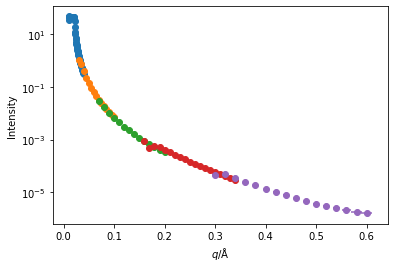

In [19]:
for s in refl.scans:
    plt.errorbar(unp.nominal_values(s.q), 
                 unp.nominal_values(s.R), 
                 yerr=unp.std_devs(s.R),
                 xerr=unp.std_devs(s.q), 
                 ls='',
                 marker='o')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'Intensity')
plt.yscale('log')
plt.show()

## Stitching and normalisation

The main reduction steps are now complete, however the scans must be brought together in a coherent dataset, normalised such that this y-axis reads the Reflectivity ($R$) (where the total external reflection is brought to $R = 1$). 

In [20]:
refl.concatenate()
refl.normalise_ter()

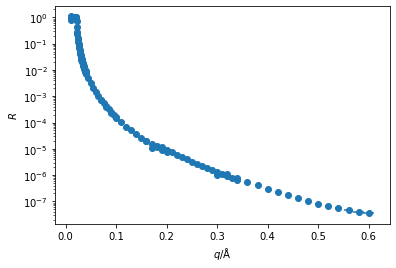

In [21]:
plt.errorbar(refl.q, refl.R, yerr=refl.dR, xerr=refl.dq, marker='o', ls='')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'$R$')
plt.yscale('log')
plt.show()

Now, we have the option to rebin the data. 
The code below will rebin the data onto 50, logarithmically distributed points in $q$. 

In [22]:
refl.rebin(number_of_q_vectors=50)

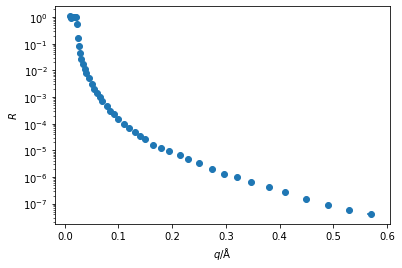

In [23]:
plt.errorbar(refl.q, refl.R, yerr=refl.dR, xerr=refl.dq, marker='o', ls='')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'$R$')
plt.yscale('log')
plt.show()

## Saving data

The last step is to save the data, this can be achieved with the `np.savetxt` function, and will output a four column text file that can be read in to most analysis packages.

In [24]:
data = np.array([refl.q, refl.R, refl.dR, refl.dq]).T
np.savetxt('refl_reduced.txt', data, header='q R dR dq')